<a href="https://colab.research.google.com/github/gagan3012/EAIS-Temporal-Bias/blob/master/RQ1_Semantic_representation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semantic Intergrity of Dates is defined as:
$$ \text{semantic integrity} = \max \left( 0, \min \left( 1, 1 - P - S - T - R\right) \right)$$

where:

- $ P = 0.1 $ if there is unnessary splitting of dates.
- $ S = 0.1 $ if separators are not preserved.
- $ T = 0.05 \times (\text{token\_count} - 5) $ if `token_count` > 5.
- $ \text{R} = 0.3 \times (1- \frac{\text{Tokenized Output} \cdot \text{Baseline}}{\|\text{Tokenized Output}\|\times\|\text{Baseline}\|})$


In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00


Processing Llama 1...
Processing Llama 2...
Processing Llama 3...
Processing Llama 3.1...
Processing Llama 3.2...
Processing OLMoE...
Processing OLMo...
Processing Mistral...
Processing Qwen...
Processing DeepSeek...
Processing Phi 3.5...
Processing Cohere...
Processing Cohere Aya...
Processing Gemma...
Processing GPT-4...
Processing GPT-4o...
Processing GPT-3.5...
Processing Davinci-003...
Processing Baseline...


<ipython-input-5-77a45e4ec8f5>:277: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Model', y='Semantic Integrity', ax=axes[0, 0], palette='Set2')
<ipython-input-5-77a45e4ec8f5>:279: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')



Model Performance Summary:
             Semantic Integrity  Token Count  Splits Components  \
Model                                                             
Baseline                  1.000        4.304              0.000   
OLMoE                     0.771        5.080              0.919   
OLMo                      0.771        5.080              0.919   
Davinci-003               0.749        5.170              1.000   
Llama 3                   0.739        4.978              1.000   
GPT-3.5                   0.739        4.978              1.000   
GPT-4                     0.739        4.978              1.000   
GPT-4o                    0.739        4.978              1.000   
Llama 3.2                 0.739        4.978              1.000   
Llama 3.1                 0.739        4.978              1.000   
Qwen                      0.420        9.304              1.000   
Cohere                    0.420        9.304              1.000   
Gemma                     0.420   

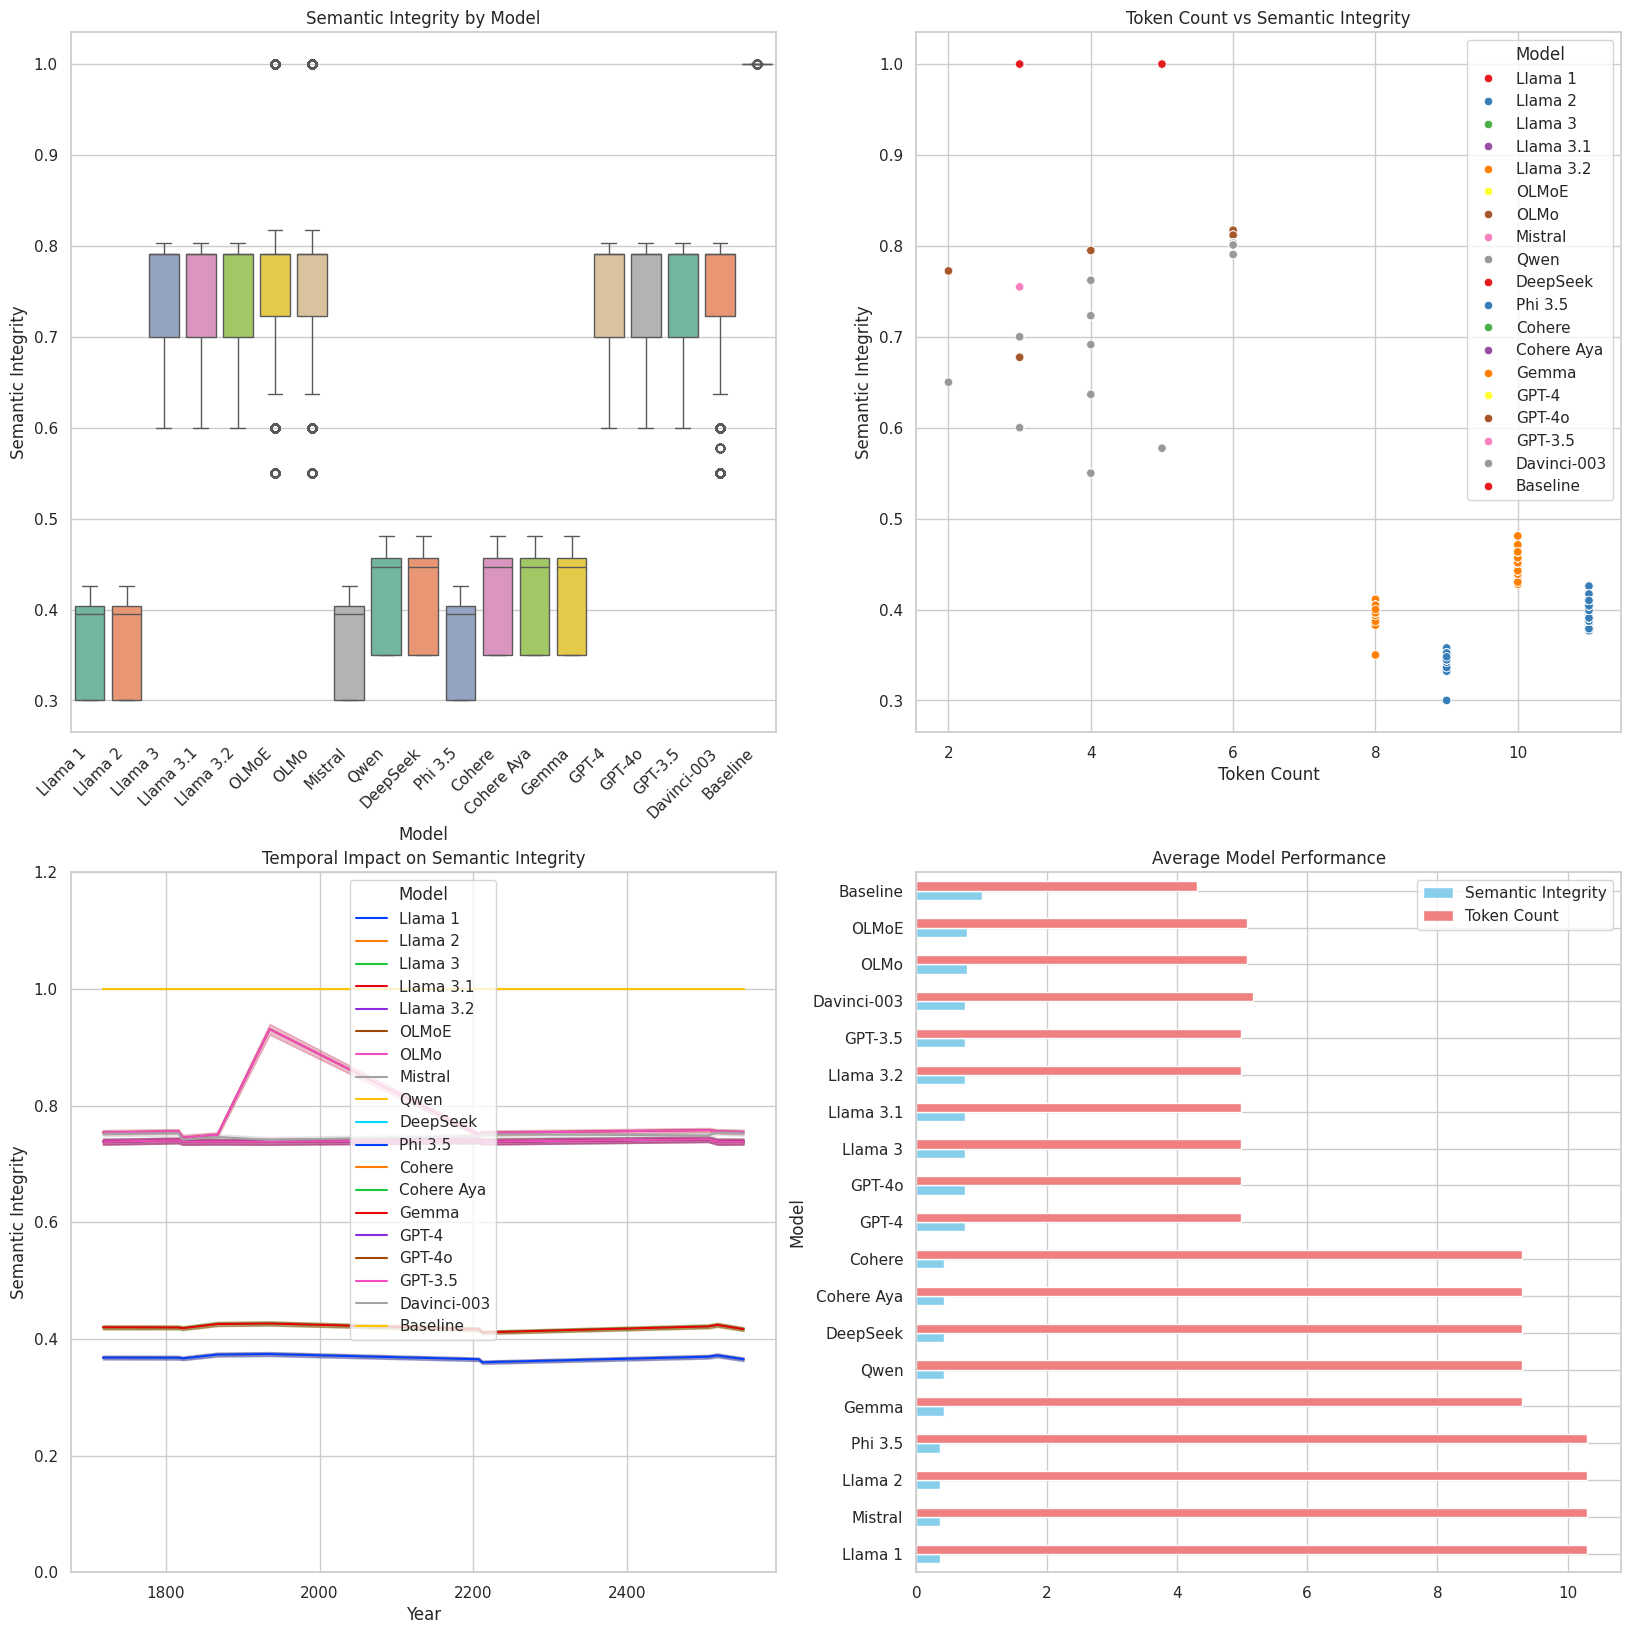

In [5]:

from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import tiktoken
from collections import Counter, defaultdict
import random
from random import sample
import re

# Function to get the appropriate tiktoken encoding based on model name
def get_tiktoken_encoding(model_name):
    encoding_map = {
        "gpt-4": "cl100k_base",
        "gpt-3.5-turbo": "cl100k_base",
        "text-davinci-003": "p50k_base",
        "text-davinci-002": "p50k_base",
        "davinci": "r50k_base",
        "gpt-4o": "o200k_base"
    }
    try:
        return tiktoken.get_encoding(encoding_map.get(model_name, "cl100k_base"))
    except:
        return tiktoken.get_encoding("cl100k_base")

def theta(tokenized_output, baseline):
    t_vals = Counter(tokenized_output)
    b_vals = Counter(baseline)

    # convert to character-vectors
    characters = list(t_vals.keys() | b_vals.keys())
    t_vect = [t_vals.get(char, 0) for char in characters]
    b_vect = [b_vals.get(char, 0) for char in characters]

    # get theta
    len_t  = np.sqrt(sum(tv*tv for tv in t_vect))
    len_b  = np.sqrt(sum(bv*bv for bv in b_vect))
    dot    = sum(tv*bv for tv,bv in zip(t_vect, b_vect))
    theta = 1 - (dot / (len_t * len_b))
    return theta


# Improved semantic analysis function
def analyze_token_semantics(tokenized_output, format_type, model_name, date_str):
    analysis = {
        'splits_date_components': False,
        'preserves_separators': False,
        'token_count': len(tokenized_output),
        'theta': 1.0,
        'semantic_integrity': 1.0
    }
    correct = baseline_tokenizer(date_str, format_type)
    # correct = " ".join(correct)
    token_str = " ".join(tokenized_output)
    expected_components = {
        'YYYY': r'\b(17|18|19|20|21|22|23|24|25)\d{2}\b',
        'MM': r'\b(0[1-9]|1[0-2])\b',
        'DD': r'\b(0[1-9]|[12][0-9]|3[01])\b'
    }

    splitters = ['-', '/', '.', ' ']
    #compare with correct
    analysis['splits_date_components'] = tokenized_output != correct

    analysis['preserves_separators'] = any(sep in token_str for sep in splitters)

    # Check if separators are preserved
    analysis['preserves_separators'] = any(sep in token_str for sep in ['-', '/', '.', ' '])

    analysis['theta'] = theta(tokenized_output, correct)

    # Adjust semantic integrity based on analysis results
    if analysis['splits_date_components']:
        analysis['semantic_integrity'] -= 0.1

    if not analysis['preserves_separators']:
        analysis['semantic_integrity'] -= 0.1

    # Adjust for excessive token count only if it suggests non-compact representation

    analysis['semantic_integrity'] -= 0.05 * (len(tokenized_output) - len(correct))

    analysis['semantic_integrity'] -= 0.3 * analysis['theta']

    # Ensure semantic integrity score stays within valid bounds
    analysis['semantic_integrity'] = max(0.0, min(1.0, analysis['semantic_integrity']))

    return analysis

from datetime import datetime

def baseline_tokenizer(date_str, format_type):

    format_map = {
        'YYYY-MM-DD': '%Y-%m-%d',
        'YYYY/MM/DD': '%Y/%m/%d',
        'YYYY.MM.DD': '%Y.%m.%d',
        'DD-MM-YYYY': '%d-%m-%Y',
        'DD/MM/YYYY': '%d/%m/%Y',
        'MM/DD/YYYY': '%m/%d/%Y',
        'YYYYMMDD': '%Y%m%d',
        'MMDDYYYY': '%m%d%Y',
        'DDMMYYYY': '%d%m%Y',
        'Month DD, YYYY': '%B %d, %Y',
        'DD Month YYYY': '%d %B %Y',
        'Month DD YYYY': '%B %d %Y',
        'YYYY/DDD': '%Y/%j',
        'DDD/YYYY': '%j/%Y',
        'YYYYDDD': '%Y%j',
        'DDDYYYY': '%j%Y',

    }

    if format_type not in format_map:
        print(f"Error: Unsupported format type '{format_type}'")
        return [date_str]

    try:
        # Parse the date using the appropriate format
        date_obj = datetime.strptime(date_str, format_map[format_type])

        # Return components while retaining separators
        if format_type == 'YYYY-MM-DD':
            return [date_obj.strftime('%Y'), '-', date_obj.strftime('%m'), '-', date_obj.strftime('%d')]
        elif format_type == 'YYYY/MM/DD':
            return [date_obj.strftime('%Y'), '/', date_obj.strftime('%m'), '/', date_obj.strftime('%d')]
        elif format_type == 'YYYY.MM.DD':
            return [date_obj.strftime('%Y'), '.', date_obj.strftime('%m'), '.', date_obj.strftime('%d')]
        elif format_type == 'DD-MM-YYYY':
            return [date_obj.strftime('%d'), '-', date_obj.strftime('%m'), '-', date_obj.strftime('%Y')]
        elif format_type == 'DD/MM/YYYY':
            return [date_obj.strftime('%d'), '/', date_obj.strftime('%m'), '/', date_obj.strftime('%Y')]
        elif format_type == 'MM/DD/YYYY':
            return [date_obj.strftime('%m'), '/', date_obj.strftime('%d'), '/', date_obj.strftime('%Y')]
        elif format_type == 'YYYYMMDD':
            return [date_obj.strftime('%Y'), date_obj.strftime('%m'), date_obj.strftime('%d')]
        elif format_type == 'MMDDYYYY':
            return [date_obj.strftime('%m'), date_obj.strftime('%d'), date_obj.strftime('%Y')]
        elif format_type == 'DDMMYYYY':
            return [date_obj.strftime('%d'), date_obj.strftime('%m'), date_obj.strftime('%Y')]
        elif format_type == 'Month DD, YYYY':
            return [date_obj.strftime('%B'), ' ', date_obj.strftime('%d'), ', ', date_obj.strftime('%Y')]
        elif format_type == 'DD Month YYYY':
            return [date_obj.strftime('%d'), ' ', date_obj.strftime('%B'), ' ', date_obj.strftime('%Y')]
        elif format_type == 'Month DD YYYY':
            return [date_obj.strftime('%B'), ' ', date_obj.strftime('%d'), ' ', date_obj.strftime('%Y')]
        elif format_type == 'YYYY/DDD':
            return [date_obj.strftime('%Y'), '/', date_obj.strftime('%j')]
        elif format_type == 'DDD/YYYY':
            return [date_obj.strftime('%j'), '/', date_obj.strftime('%Y')]
        elif format_type == 'YYYYDDD':
            return [date_obj.strftime('%Y'), date_obj.strftime('%j')]
        elif format_type == 'DDDYYYY':
            return [date_obj.strftime('%j'), date_obj.strftime('%Y')]
        else:
            return [date_str]

    except ValueError as e:
        print(f"Error: {e}")
        return [date_str]

# Function to generate date variations
from random import sample

def generate_date_variations(base_formats):
    """
    Generate date variations based on base formats.

    Args:
        base_formats (list): List of date formats to generate variations for.

    Returns:
        list: A list of tuples with the generated date string, year, and format.
    """
    date_variations = []
    # Randomly sample years, months, days, and Julian days
    years = sample(list(range(1600, 2600)), 10)  # Sample 10 random years
    months = sample(list(range(1, 13)), 10)
    days = sample(list(range(1, 29)),10)  # Avoid invalid dates
    julian_days = sample(list(range(1, 367)), 10)  # Sample 10 random Julian days

    # Month names for text formats
    month_names = {
        1: ('January', 'Jan'),
        2: ('February', 'Feb'),
        3: ('March', 'Mar'),
        4: ('April', 'Apr'),
        5: ('May', 'May'),
        6: ('June', 'Jun'),
        7: ('July', 'Jul'),
        8: ('August', 'Aug'),
        9: ('September', 'Sep'),
        10: ('October', 'Oct'),
        11: ('November', 'Nov'),
        12: ('December', 'Dec')
    }

    # Generate date strings for standard formats
    for year in years:
        for month in months:
            for day in days:
                for fmt in base_formats:
                    if 'DDD' not in fmt:  # Exclude Julian day formats
                        date_str = fmt.replace('YYYY', f'{year:04d}')\
                                      .replace('MM', f'{month:02d}')\
                                      .replace('DD', f'{day:02d}')
                        date_variations.append((date_str, year, fmt))

    # Generate date strings for Julian day formats
    for year in years:
        for day in julian_days:
            for fmt in base_formats:
                if 'DDD' in fmt:  # Only include Julian day formats
                    date_str = fmt.replace('YYYY', f'{year:04d}')\
                                  .replace('DDD', f'{day:03d}')  # Proper zero-padded Julian day
                    date_variations.append((date_str, year, fmt))

    return date_variations

# Function to tokenize dates and analyze their representation
# Function to tokenize dates and analyze their representation
def tokenize_dates(date_variations, model_name, to_print_name):
    results = []

    if model_name == "baseline":
        # Use baseline tokenizer for perfect tokenization
        tokenize_func = lambda x, fmt: baseline_tokenizer(x, fmt)
    elif model_name in ["gpt-4", "gpt-3.5-turbo", "text-davinci-003", "gpt-4o"]:
        tokenizer = get_tiktoken_encoding(model_name)
        tokenize_func = lambda x: tokenizer.encode(x)
        detokenize_func = lambda x: tokenizer.decode(x)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        tokenize_func = lambda x: tokenizer.encode(x, add_special_tokens=False)
        detokenize_func = lambda x: tokenizer.decode(x)

    for date_str, year, fmt in date_variations:
        if model_name == "baseline":
            tokenized_output = tokenize_func(date_str, fmt)
        else:
            tokens = tokenize_func(date_str)
            if isinstance(tokenizer, tiktoken.Encoding):
                tokenized_output = [detokenize_func([t]) for t in tokens]
            else:
                tokenized_output = tokenizer.convert_ids_to_tokens(tokens)

        semantic_analysis = analyze_token_semantics(tokenized_output, fmt, model_name, date_str)

        period = ("Historical (Pre-2000)" if year < 2000
                 else "Contemporary (2000-2024)" if 2000 <= year <= 2024
                 else "Future (Post-2024)")
        century = f"{(year // 100) + 1}th Century"

        results.append({
            'Model': to_print_name,
            'Date Format': date_str,
            'Year': year,
            'Time Period': period,
            'Century': century,
            'Token Count': len(tokenized_output),
            'Tokenized Output': " ".join(tokenized_output),
            'Semantic Integrity': semantic_analysis['semantic_integrity'],
            'Splits Components': semantic_analysis['splits_date_components'],
            'Preserves Separators': semantic_analysis['preserves_separators']
        })

    return pd.DataFrame(results)

# Enhanced function for better visualization
def plot_semantic_analysis(data):
    sns.set(style="whitegrid", context="notebook")
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    # fig.suptitle('Date Tokenization Semantic Analysis', fontsize=20, y=1)

    sns.boxplot(data=data, x='Model', y='Semantic Integrity', ax=axes[0, 0], palette='Set2')
    axes[0, 0].set_title('Semantic Integrity by Model')
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

    sns.scatterplot(data=data, x='Token Count', y='Semantic Integrity', hue='Model', ax=axes[0, 1], palette='Set1')
    axes[0, 1].set_title('Token Count vs Semantic Integrity')

    sns.lineplot(data=data, x='Year', y='Semantic Integrity', hue='Model', ax=axes[1, 0], palette='bright', legend='brief')
    axes[1, 0].set_title('Temporal Impact on Semantic Integrity')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Semantic Integrity')
    # axes[1, 0].legend(title='Model', loc='upper left')
    axes[1, 0].set_ylim(0, 1.2)

    model_perf = data.groupby('Model')[['Semantic Integrity', 'Token Count']].mean().sort_values(by='Semantic Integrity')
    model_perf.plot(kind='barh', ax=axes[1, 1], color=['skyblue', 'lightcoral'])
    axes[1, 1].set_title('Average Model Performance')


def main():
    base_formats = [
        'YYYY-MM-DD',
        'YYYY/MM/DD',
        'YYYY.MM.DD',
        'DD-MM-YYYY',
        'DD/MM/YYYY',
        'MM/DD/YYYY',
        'YYYYMMDD',
        'MMDDYYYY',
        'DDMMYYYY',
        'YYYY/DDD',
        'DDD/YYYY'
    ]

    model_list = {
        'relaxml/Llama-1-7b-hf': 'Llama 1',
        'meta-llama/Llama-2-7b-hf': 'Llama 2',
        'meta-llama/Meta-Llama-3-8B-Instruct': 'Llama 3',
        'meta-llama/Llama-3.1-8B-Instruct': 'Llama 3.1',
        'meta-llama/Llama-3.2-1B-Instruct' : "Llama 3.2",
        'allenai/OLMoE-1B-7B-0924-Instruct': 'OLMoE',
        'allenai/OLMo-1B-0724-hf': 'OLMo',
        'mistralai/Mistral-7B-Instruct-v0.3': 'Mistral',
        'Qwen/Qwen2.5-7B-Instruct': 'Qwen',
        'deepseek-ai/DeepSeek-V2.5': 'DeepSeek',
        'microsoft/Phi-3.5-mini-instruct':'Phi 3.5',
        'CohereForAI/c4ai-command-r-plus-08-2024':'Cohere',
        'CohereForAI/aya-expanse-32b':'Cohere Aya',
        "google/gemma-2-2b-it":'Gemma',
        'gpt-4': 'GPT-4',
        'gpt-4o': 'GPT-4o',
        'gpt-3.5-turbo': 'GPT-3.5',
        'text-davinci-003': 'Davinci-003',
        'baseline': 'Baseline'
    }

    date_variations = generate_date_variations(base_formats)
    all_data = []

    for model_name, print_name in model_list.items():
        print(f"Processing {print_name}...")
        df = tokenize_dates(date_variations, model_name=model_name, to_print_name=print_name)
        all_data.append(df)

    combined_data = pd.concat(all_data, ignore_index=True)

    # Generate visualizations and analysis
    fig = plot_semantic_analysis(combined_data)

    # Save results
    combined_data.to_csv('date_tokenization_semantic_analysis.csv', index=False)

    # Print summary statistics
    summary = combined_data.groupby('Model').agg({
        'Semantic Integrity': 'mean',
        'Token Count': 'mean',
        'Splits Components': 'mean',
        'Preserves Separators': 'mean'
    }).round(3)

    summary = summary.sort_values('Semantic Integrity', ascending=False)

    print("\nModel Performance Summary:")
    print(summary)

    return summary, combined_data


summary, combined_data = main()

In [7]:
summary

,Semantic Integrity,Token Count,Splits Components,Preserves Separators
Model,,,,
Baseline,1.000,4.304,0.000,1.0
OLMoE,0.771,5.080,0.919,1.0
OLMo,0.771,5.080,0.919,1.0
Davinci-003,0.749,5.170,1.000,1.0
Llama 3,0.739,4.978,1.000,1.0
GPT-3.5,0.739,4.978,1.000,1.0
GPT-4,0.739,4.978,1.000,1.0
GPT-4o,0.739,4.978,1.000,1.0
Llama 3.2,0.739,4.978,1.000,1.0


In [8]:
new_df = combined_data.groupby(['Model']).sample(n=1, random_state=49)
new_df

,Model,Date Format,Year,Time Period,Century,Token Count,Tokenized Output,Semantic Integrity,Splits Components,Preserves Separators
173149,Baseline,10272552,2552,Future (Post-2024),26th Century,3,10 27 2552,1.000000,False,True
103352,Cohere,1867/10/24,1867,Historical (Pre-2000),19th Century,10,1 8 6 7 / 1 0 / 2 4,0.471218,True,True
113546,Cohere Aya,05/24/1718,1718,Historical (Pre-2000),18th Century,10,0 5 / 2 4 / 1 7 1 8,0.471218,True,True
158410,Davinci-003,16-08-1867,1867,Historical (Pre-2000),19th Century,6,16 - 08 - 18 67,0.790535,True,True
87741,DeepSeek,1822-05-24,1822,Historical (Pre-2000),19th Century,10,1 8 2 2 - 0 5 - 2 4,0.456904,True,True
155695,GPT-3.5,16051816,1816,Historical (Pre-2000),19th Century,3,160 518 16,0.700000,True,True
129810,GPT-4,2212.06.14,2212,Future (Post-2024),23th Century,6,221 2 . 06 . 14,0.790535,True,True
144836,GPT-4o,09/24/2518,2518,Future (Post-2024),26th Century,6,09 / 24 / 251 8,0.790535,True,True
121867,Gemma,10091867,1867,Historical (Pre-2000),19th Century,8,1 0 0 9 1 8 6 7,0.350000,True,True
524,Llama 1,2207.09.27,2207,Future (Post-2024),23th Century,11,▁ 2 2 0 7 . 0 9 . 2 7,0.394573,True,True


In [9]:
combined_data.sort_values('Semantic Integrity').groupby(['Model']).head(1)

,Model,Date Format,Year,Time Period,Century,Token Count,Tokenized Output,Semantic Integrity,Splits Components,Preserves Separators
14139,Llama 2,05271822,1822,Historical (Pre-2000),19th Century,9,▁ 0 5 2 7 1 8 2 2,0.30,True,True
73192,Mistral,28111816,1816,Historical (Pre-2000),19th Century,9,▁ 2 8 1 1 1 8 1 6,0.30,True,True
94510,Phi 3.5,27111867,1867,Historical (Pre-2000),19th Century,9,▁ 2 7 1 1 1 8 6 7,0.30,True,True
7638,Llama 1,25520527,2552,Future (Post-2024),26th Century,9,▁ 2 5 5 2 0 5 2 7,0.30,True,True
78979,Qwen,18220425,1822,Historical (Pre-2000),19th Century,8,1 8 2 2 0 4 2 5,0.35,True,True
121568,Gemma,18670627,1867,Historical (Pre-2000),19th Century,8,1 8 6 7 0 6 2 7,0.35,True,True
115059,Cohere Aya,18220625,1822,Historical (Pre-2000),19th Century,8,1 8 2 2 0 6 2 5,0.35,True,True
84437,DeepSeek,10072212,2212,Future (Post-2024),23th Century,8,1 0 0 7 2 2 1 2,0.35,True,True
108497,Cohere,06202552,2552,Future (Post-2024),26th Century,8,0 6 2 0 2 5 5 2,0.35,True,True
161483,Davinci-003,03061822,1822,Historical (Pre-2000),19th Century,4,0 306 18 22,0.55,True,True


In [10]:
combined_data.sort_values('Semantic Integrity').groupby(['Model']).tail(1)

,Model,Date Format,Year,Time Period,Century,Token Count,Tokenized Output,Semantic Integrity,Splits Components,Preserves Separators
6204,Llama 1,24-07-1935,1935,Historical (Pre-2000),20th Century,11,▁ 2 4 - 0 7 - 1 9 3 5,0.425794,True,True
11518,Llama 2,09/25/1867,1867,Historical (Pre-2000),19th Century,11,▁ 0 9 / 2 5 / 1 8 6 7,0.425794,True,True
94316,Phi 3.5,25-09-1867,1867,Historical (Pre-2000),19th Century,11,▁ 2 5 - 0 9 - 1 8 6 7,0.425794,True,True
67075,Mistral,1867.04.25,1867,Historical (Pre-2000),19th Century,11,▁ 1 8 6 7 . 0 4 . 2 5,0.425794,True,True
107464,Cohere,1935-04-28,1935,Historical (Pre-2000),20th Century,10,1 9 3 5 - 0 4 - 2 8,0.480931,True,True
112733,Cohere Aya,1867.09.24,1867,Historical (Pre-2000),19th Century,10,1 8 6 7 . 0 9 . 2 4,0.480931,True,True
125884,Gemma,1935.04.27,1935,Historical (Pre-2000),20th Century,10,1 9 3 5 . 0 4 . 2 7,0.480931,True,True
88374,DeepSeek,24-06-1935,1935,Historical (Pre-2000),20th Century,10,2 4 - 0 6 - 1 9 3 5,0.480931,True,True
79775,Qwen,1935/07/28,1935,Historical (Pre-2000),20th Century,10,1 9 3 5 / 0 7 / 2 8,0.480931,True,True
24982,Llama 3,10-10-2518,2518,Future (Post-2024),26th Century,6,10 - 10 - 251 8,0.802982,True,True


In [ ]:
combined_data[(combined_data['Date Format'] == '10271606')].sort_values(by='Semantic Integrity', ascending=False)

,Model,Date Format,Year,Time Period,Century,Token Count,Tokenized Output,Semantic Integrity,Splits Components,Preserves Separators
